In [223]:
# Import required libraries
import numpy as np
import pandas as pd
import sweetviz as sw
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import stanza
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [224]:
# convert to pandas dataframe
df = pd.read_json('Data/News_Category_Dataset_IS_course.json', lines=True)

In [225]:
df.shape

(148122, 6)

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148122 entries, 0 to 148121
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               148122 non-null  object        
 1   headline           147391 non-null  object        
 2   category           148122 non-null  object        
 3   short_description  147386 non-null  object        
 4   authors            148122 non-null  object        
 5   date               148122 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 6.8+ MB


In [227]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
1,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
2,https://www.huffpost.com/entry/dodgers-basebal...,"Maury Wills, Base-Stealing Shortstop For Dodge...",SPORTS,"Maury Wills, who helped the Los Angeles Dodger...","Beth Harris, AP",2022-09-20
3,https://www.huffpost.com/entry/golden-globes-r...,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",,2022-09-20
4,https://www.huffpost.com/entry/biden-us-forces...,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,,2022-09-19


In [228]:
df.loc[0, 'link']

'https://www.huffpost.com/entry/funniest-tweets-cats-dogs-september-17-23_n_632de332e4b0695c1d81dc02'

In [229]:
print("Unique categories:",df['category'].nunique())

Unique categories: 15


In [230]:
# report = sw.analyze(df)

In [231]:
# report.show_notebook(layout='vertical', w=1200, h=1440, scale=1)

In [232]:
df1 = df.copy() #Backup

In [233]:
df = df.dropna()

In [234]:
# sort out datatypes
# date
df['date'] = pd.to_datetime(df['date'], unit='ms').dt.strftime('%Y')
# headline
df['headline'] = df['headline'].astype(str)
# authors
df['authors'] = df['authors'].astype(str)
# link
df['link'] = df['link'].astype(str)
# short_description
df['short_description'] = df['short_description'].astype(str)
# category as a category
df['category'] = df['category'].astype(str)

# Exploratory Data Analysis

## Missing values

In [235]:
# look for empty strings across all columns
(df == '').sum()

link                     0
headline                 3
category                 0
short_description    11390
authors              24164
date                     0
dtype: int64

In [236]:
((df == '').sum()  / df.shape[0]) * 100

link                  0.000000
headline              0.002046
category              0.000000
short_description     7.766527
authors              16.476765
date                  0.000000
dtype: float64

In [237]:
# replace empty strings with null
df = df.replace(r'^\s*$', np.nan, regex=True)

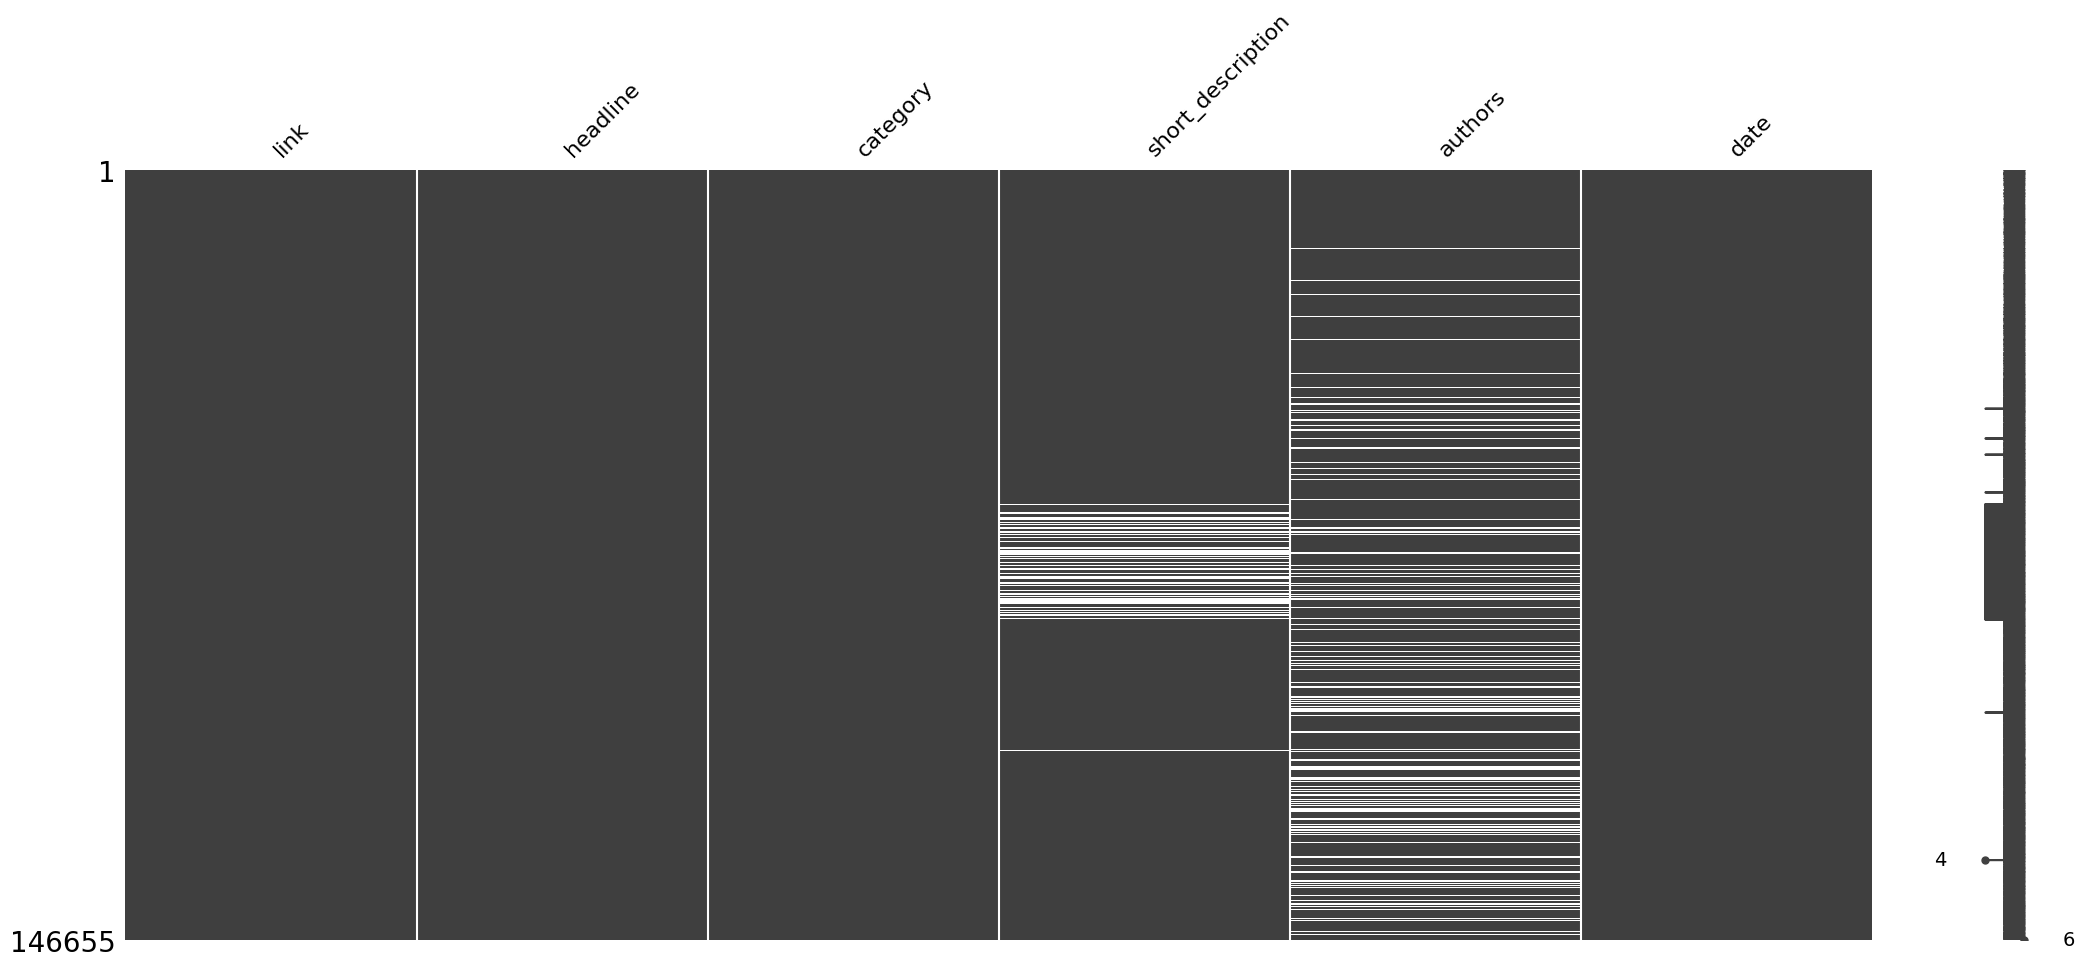

In [238]:
import missingno as msno
import matplotlib.pyplot as plt

# Visualize missing values
msno.matrix(df)
plt.show()

In [239]:
#TODO: Hacky but convert back to "" for now
df = df.replace(np.nan, '', regex=True)

In [240]:
print(df[(df['authors'] == '') & (df['short_description'] == '') & (df['headline'] == '')].shape[0])
print(df[(df['authors'] == '') & (df['short_description'] == '')].shape[0])

0
2238


In [241]:
df[df['headline'] == '']

,link,headline,category,short_description,authors,date
62046,https://www.huffingtonpost.com/entry/lincoln-2...,,POLITICS,,"Robert Moran, ContributorRobert Moran leads Br...",2015
72619,https://www.huffingtonpost.com/entry/disney-ce...,,BUSINESS,,"Gary Snyder, ContributorWriter and Media Strat...",2015
80016,https://www.huffingtonpost.com/entry/beverly-h...,,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strat...",2014


In [242]:
# remove observations with headline as empty string
df = df[df['headline'] != '']
# TODO: should we remove short_description as well if empty?
# because the missing short description are only 7% of dataset and in my opinion (Oskar) are necessary for the proper classification I decided to drop them
df = df[df['short_description'] != '']
# the missing authors after cleaning the descriptions are still 17% and we can probably get some classification put of the description, I decided to leave them in the dataset
# TODO: what about authors?
df = df[df['authors'] != '']

In [243]:
# TODO: for now I will just remove all observations with empty strings (missing values)
# df = df[(df != '').all(1)]
((df == '').sum()  / df.shape[0]) * 100

link                 0.0
headline             0.0
category             0.0
short_description    0.0
authors              0.0
date                 0.0
dtype: float64

Insights:
- There is missingness
- Mostly in Short description and Author (and sometimes both are missing)
- Only in 3 observations is there no headline and in all cases there is no short-description

### Category

In [244]:
df['category'].value_counts()

POLITICS          29373
ENTERTAINMENT     13330
WELLNESS          12808
TRAVEL             7953
STYLE & BEAUTY     7215
PARENTING          6456
HEALTHY LIVING     5018
QUEER VOICES       4661
FOOD & DRINK       4481
BUSINESS           4333
COMEDY             3901
SPORTS             3584
HOME & LIVING      3488
PARENTS            3462
BLACK VOICES       3276
Name: category, dtype: int64

In [245]:
df['category'].value_counts() / df.shape[0] * 100

POLITICS          25.916057
ENTERTAINMENT     11.761177
WELLNESS          11.300611
TRAVEL             7.017002
STYLE & BEAUTY     6.365858
PARENTING          5.696186
HEALTHY LIVING     4.427426
QUEER VOICES       4.112441
FOOD & DRINK       3.953626
BUSINESS           3.823044
COMEDY             3.441887
SPORTS             3.162195
HOME & LIVING      3.077493
PARENTS            3.054553
BLACK VOICES       2.890444
Name: category, dtype: float64

In [246]:
counts = df['category'].value_counts()
cat_df = pd.DataFrame({'category': counts.index, 'count': counts.values})

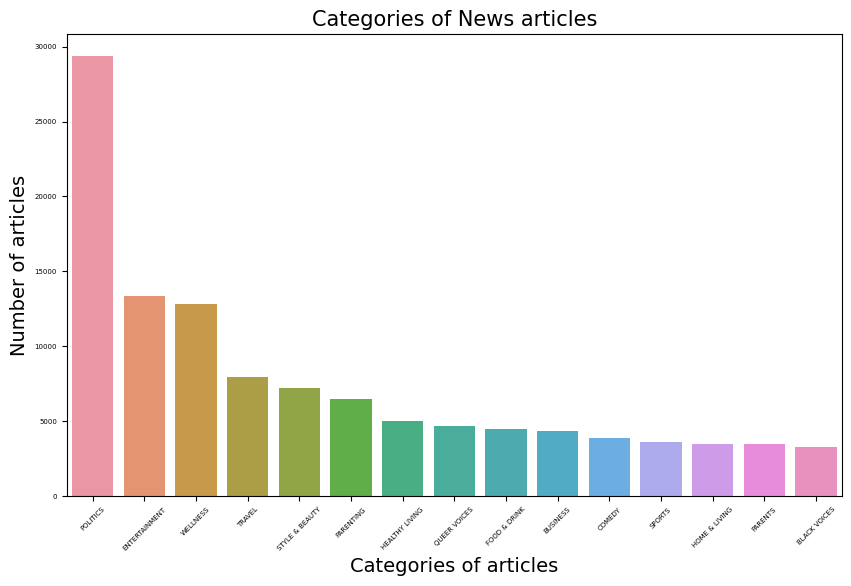

,category,count
0,POLITICS,29373
1,ENTERTAINMENT,13330
2,WELLNESS,12808
3,TRAVEL,7953
4,STYLE & BEAUTY,7215
5,PARENTING,6456
6,HEALTHY LIVING,5018
7,QUEER VOICES,4661
8,FOOD & DRINK,4481
9,BUSINESS,4333


In [247]:
# Visualize top 10 categories and proportion of each category's in dataset
plt.figure(figsize=(10,6))
df_sorted = cat_df.sort_values(by='count', ascending=False)
sns.barplot(x='category', y='count', data=df_sorted, order=df_sorted['category'])
plt.title("Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()
cat_df

In [248]:
df['category'] = df['category'].replace('PARENTING', 'PARENTS')
df['category'] = df['category'].replace('HEALTHY LIVING', 'WELLNESS')
df['category'] = df['category'].replace('COMEDY', 'ENTERTAINMENT')
df['category'] = df['category'].replace('BLACK VOICES', 'MINORITY VOICES')
df['category'] = df['category'].replace('QUEER VOICES', 'MINORITY VOICES')

In [249]:
counts = df['category'].value_counts()
cat_df = pd.DataFrame({'category': counts.index, 'count': counts.values})

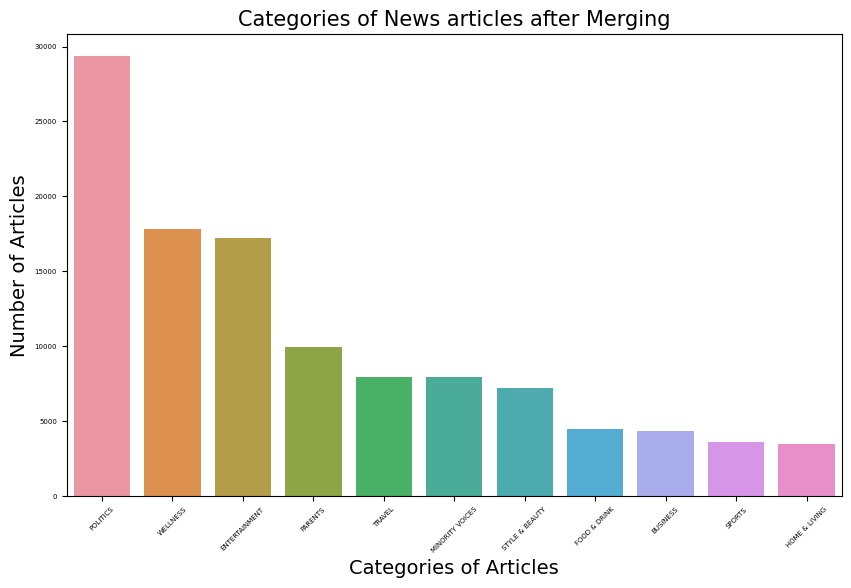

,category,count
0,POLITICS,29373
1,WELLNESS,17826
2,ENTERTAINMENT,17231
3,PARENTS,9918
4,TRAVEL,7953
5,MINORITY VOICES,7937
6,STYLE & BEAUTY,7215
7,FOOD & DRINK,4481
8,BUSINESS,4333
9,SPORTS,3584


In [250]:
# Visualize top 10 categories and proportion of each category's in dataset
plt.figure(figsize=(10,6))
df_sorted = cat_df.sort_values(by='count', ascending=False)
sns.barplot(x='category', y='count', data=df_sorted, order=df_sorted['category'])
plt.title("Categories of News articles after Merging", size=15)
plt.xlabel("Categories of Articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of Articles", size=14)
plt.show()
cat_df

### Authors

In [251]:
#This is taking only the words until the first comma, it destroys few entries where there are two authors separated by comma, but it is not often, so we can leave with that
def extract_text(row):
    comma_index = row.find(',')
    semicolon_index = row.find(';')
    parenthesis_index = row.find('(')
    indices = [index for index in [comma_index, semicolon_index, parenthesis_index] if index != -1]
    if indices:
        min_index = min(indices)
        return row[:min_index]
    else:
        return row

In [252]:
df_authors = df.copy()

In [253]:
# df_authors['ExtractedAuthor'] = df['authors'].apply(extract_text)
# unique authors count
# len(df_authors['ExtractedAuthor'].unique())
# df_authors[['ExtractedAuthor', 'authors']]
# df['authors'] = df['authors'].apply(extract_text)

In [254]:
# Percentage of authors with less than 10 articles
(df['authors'].value_counts() < 10).sum() / df.shape[0] * 100

15.487166818129683

In [255]:
df['authors'].value_counts()

Lee Moran                                                                                          2031
Ron Dicker                                                                                         1633
Cole Delbyck                                                                                       1253
Reuters, Reuters                                                                                   1128
Mary Papenfuss                                                                                     1103
                                                                                                   ... 
Meerabelle Dey, ContributorWriter, columnist for Beliefnet and co-founder of the blog, La...          1
Broderick Johnson, Contributor Assistant to the President and Cabinet Secretary; Chair of th...       1
Paul Loeb, ContributorAuthor, 'Soul of a Citizen' and 'The Impossible Will Take a Li...               1
Kara Sundlun, ContributorNews Anchor, Talk Show Host, Author, Mo

In [256]:
df[df['authors'].str.len() > 50]

,link,headline,category,short_description,authors,date
81,https://www.huffpost.com/entry/biden-student-l...,Student Loan Borrowers Await Biden Plan On Deb...,POLITICS,If Biden's plan survives legal challenges that...,"Seung Min Kim, Michael Balsamo, Chris Megerian...",2022
86,https://www.huffpost.com/entry/after-delay-bid...,"After Delay, Biden Readies Student Loan Help, ...",POLITICS,The precise details of President Joe Biden’s p...,"Seung Min Kim, Michael Balsamo and Chris Meger...",2022
792,https://www.huffpost.com/entry/trump-tweets-ra...,The Best And Worst Trump Tweets Over The Past ...,POLITICS,Here you go.,"Amanda Terkel, Paige Lavender, Richard Kim, an...",2022
1222,https://www.huffpost.com/entry/police-say-they...,Police Say They’re Ready For Rally Supporting ...,POLITICS,The Capitol police are taking no chances as th...,"By Colleen Long, Michael Balsamo and Ashraf Kh...",2021
1298,https://www.huffpost.com/entry/taliban-us-airs...,U.S. Drone Strike Kills Suicide Bombers Target...,POLITICS,The strike hit a vehicle carrying “multiple su...,"Kathy Gannon, Lolita C. Baldor, Tameem Akhgar ...",2021
...,...,...,...,...,...,...
148106,https://www.huffingtonpost.com/entry/gay-divor...,Gay Divorce: How the Collaborative Family Law ...,MINORITY VOICES,One of the many unjust results of a state lega...,"Thomas Greenwald, Contributor\nPartner, Gorans...",2012
148107,https://www.huffingtonpost.com/entry/the-six-p...,Episode 87: Life Is a Highway (AUDIO),MINORITY VOICES,"On this episode of The Six Pack, we hit up the...","The Six Pack, Contributor\nRadio show hosted b...",2012
148111,https://www.huffingtonpost.com/entry/four-more...,Four More Bank Closures Mark the Week of Janua...,BUSINESS,The general pattern of the FDIC closing banks ...,"Dennis Santiago, Contributor\nGlobal Risk and ...",2012
148114,https://www.huffingtonpost.com/entry/world-eco...,"At World Economic Forum, Fear of Global Contag...",BUSINESS,"For decades, as crises have assailed developin...","Peter S. Goodman, Contributor\nExecutive Busin...",2012


In [257]:
# look at the relationship between authors and category
# for top 100 authors
# get top 100 authors
top_100_authors = df['authors'].value_counts()[1:101].index.tolist()
# look at the distribution of categories for each of these authors
df_top_100_authors = df[df['authors'].isin(top_100_authors)]

# Calculate the total number of publications for each author
author_total_publications = df_top_100_authors.groupby('authors').size().sort_values(ascending=False)

df_top_100_authors.groupby(['authors', 'category']).size()

authors                category       
Alana Horowitz Satlin  BUSINESS            16
                       ENTERTAINMENT       16
                       MINORITY VOICES      8
                       PARENTS              1
                       POLITICS           179
                                         ... 
Zach Carter            BUSINESS             1
                       ENTERTAINMENT        3
                       POLITICS           191
Zeba Blay              ENTERTAINMENT       10
                       MINORITY VOICES    173
Length: 423, dtype: int64

In [258]:
# for Elyse Wanshel get the distribution of categories
df[df['authors'] == 'Elyse Wanshel']['category'].value_counts()

ENTERTAINMENT      322
MINORITY VOICES     59
POLITICS            23
PARENTS             18
WELLNESS             7
SPORTS               4
TRAVEL               3
STYLE & BEAUTY       1
BUSINESS             1
Name: category, dtype: int64

<Axes: xlabel='authors'>

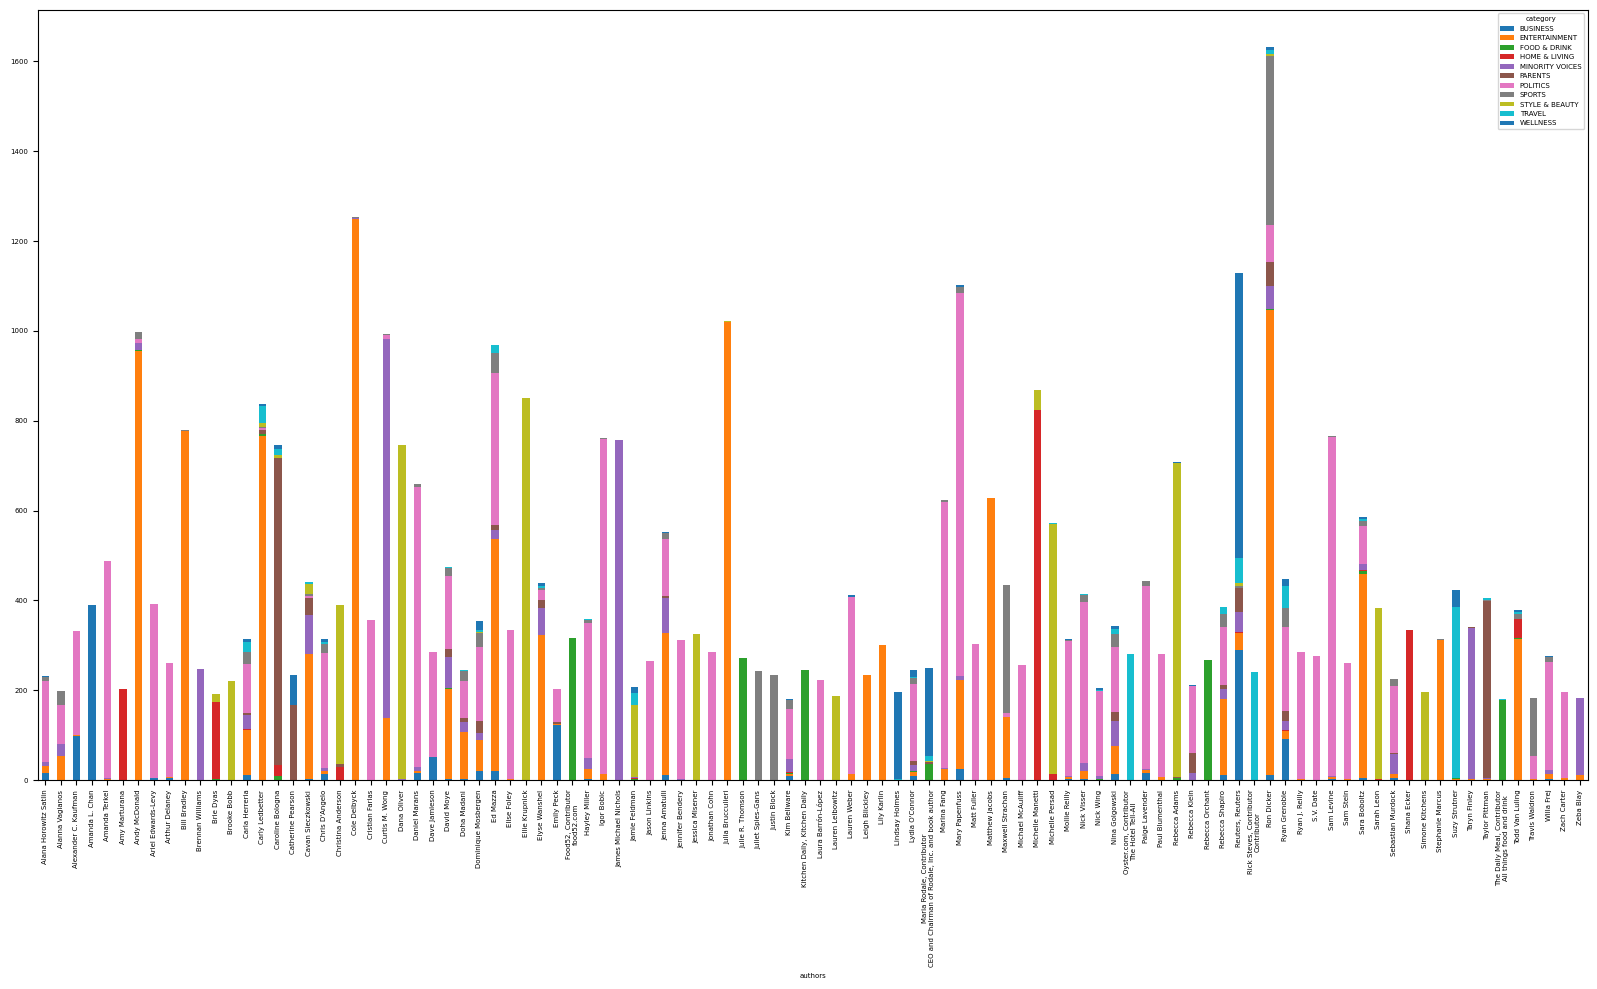

In [259]:
# plot the distribution of categories for top 100 authors
df_top_100_authors.groupby(['authors', 'category']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))

Insights:
- Some authors are just names whereas others have descriptions of the author
- Further some other authors are actually institutions rather than individuals
- There are a lot of authors that have more than one article in the dataset - almost 90% of authors have over 10 articles
- Author seems like it could be a useful predictor of Category
- There is a fair amount of missing data! How to resolve this!


### Link

In [260]:
# extract the website name from the link using regex
import re
df['website'] = df['link'].apply(lambda x: re.findall(r'(?<=www.)[^/]+', x)[0])

In [261]:
df['website'].unique().shape[0] / df.shape[0] * 100

0.0017646176514703675

In [262]:
df['website'].value_counts()

huffingtonpost.com    108174
huffpost.com            5165
Name: website, dtype: int64

Insight:
- Link is not useful all links are from huffingtonpost - should've known that :(

### Date

In [263]:
counts = df['date'].value_counts()
cat_df = pd.DataFrame({'date': counts.index, 'count': counts.values})

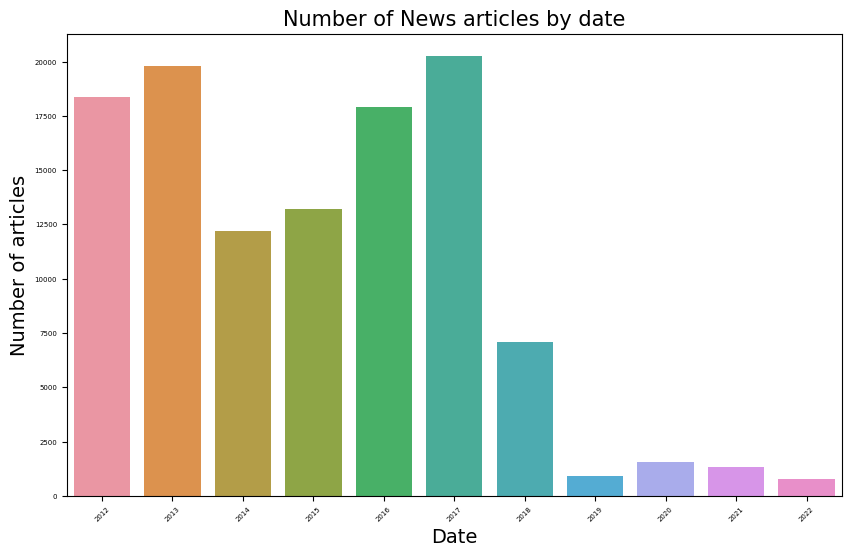

In [264]:
cat_df = cat_df.sort_values(by='date')
plt.figure(figsize=(10,6))
sns.barplot(x='date', y='count', data=cat_df)
plt.title("Number of News articles by date", size=15)
plt.xlabel("Date", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

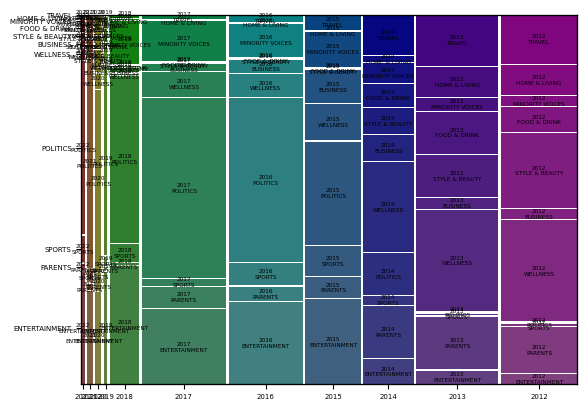

In [265]:
# association between date and category
# for each category, get the distribution of dates
df.groupby(['category', 'date']).size()
# plot as mosaic plot
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 5
mosaic(df, ['date', 'category'])
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()


# Data Wranling

In [266]:
# drop unnecessary features
df.drop(['website'], axis=1, inplace=True)
# no link
df.drop(['link'], axis=1, inplace=True)

In [267]:
df.drop(df[df['category'] == "POLITICS"].index, inplace = True)
df.drop(df[df['category'] == "WELLNESS"].index, inplace = True)
df.drop(df[df['category'] == "ENTERTAINMENT"].index, inplace = True)

In [268]:
# take a sample of the data where we have 10% of the data evenly distributed across categories
df = df.groupby('category').sample(frac=0.05, random_state=42)

# Preprocessing

In [269]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Download necessary resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer and Stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benjo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benjo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\benjo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [270]:
# Function to preprocess text
def preprocess_text(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())  # Convert text to lowercase

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    preprocessed_text = ' '.join(lemmatized_words)

    # Stemming (uncomment if you want to use stemming)
    # stemmed_words = [stemmer.stem(word) for word in words]
    # preprocessed_text = ' '.join(stemmed_words)

    return preprocessed_text

In [271]:
df['short_description']

74905     Religion and politics are generally considered...
55949     Unfortunately, personal reputation often gets ...
78005     Just like attorneys and medical professionals,...
940       Retailers are expected to usher in the unoffic...
121077    Imagine your car taking you from your driveway...
                                ...                        
102199    Despite the uneven cobblestoned streets of the...
119702    The pine branches gently grazed my jacket slee...
114531    San Francisco has no shortage of trendy new re...
64502     Girls run the world, and Beyoncé officially ru...
109748    The larger-than-life place in the show is so s...
Name: short_description, Length: 2446, dtype: object

In [272]:
# Apply the function to preprocess the text
df['headline_clean'] = df['headline'].apply(preprocess_text)
df['short_description_clean'] = df['short_description'].apply(preprocess_text)

In [273]:
# pre-process authors as well
df['authors_clean'] = df['authors'].apply(preprocess_text)

In [274]:
df['headline'].head()

74905             6 Tips for Indian Managers New to America
55949     This Will Be Mark Zuckerberg's Biggest Challen...
78005     10 Reasons To Work With A Broker During Your N...
940       Stores Kick Off Black Friday But Pandemic Woes...
121077    Going Down The Road -- In A Car That Drives It...
Name: headline, dtype: object

In [275]:
df['headline_clean'].head()

74905                       tip indian manager new america
55949     mark zuckerberg biggest challenge philanthropist
78005                reason work broker next office search
940            store kick black friday pandemic woe linger
121077                                going road car drive
Name: headline_clean, dtype: object

In [276]:
df['short_description'].head()

74905     Religion and politics are generally considered...
55949     Unfortunately, personal reputation often gets ...
78005     Just like attorneys and medical professionals,...
940       Retailers are expected to usher in the unoffic...
121077    Imagine your car taking you from your driveway...
Name: short_description, dtype: object

In [277]:
df['short_description_clean'].head()

74905     religion politics generally considered topic b...
55949     unfortunately personal reputation often get wa...
78005     like attorney medical professional commercial ...
940       retailer expected usher unofficial start holid...
121077    imagine car taking driveway home office parkin...
Name: short_description_clean, dtype: object

In [278]:
df['authors'].head()

74905     Gunjan Bagla, ContributorManagement consultant...
55949                                           Shane Ferro
78005     Frank Chalupa, ContributorPresident & Co-Found...
940                                   ANNE D'INNOCENZIO, AP
121077    Don Tapscott, Contributor\nCo-Author, with son...
Name: authors, dtype: object

In [279]:
df['authors_clean'].head()

74905     gunjan bagla contributormanagement consultant ...
55949                                           shane ferro
78005     frank chalupa contributorpresident amata offic...
940                                                 anne ap
121077    tapscott contributor son alex tapscott blockch...
Name: authors_clean, dtype: object

## Test and Training Split

In [280]:
df.columns

Index(['headline', 'category', 'short_description', 'authors', 'date',
       'headline_clean', 'short_description_clean', 'authors_clean'],
      dtype='object')

In [281]:
df = df[['headline_clean', 'short_description_clean', 'authors_clean', 'category']]

In [282]:
X_train, X_test, y_train, y_test = train_test_split(df[['headline_clean', 'short_description_clean', 'authors_clean']],
                                                    df['category'], 
                                                    test_size=0.2, 
                                                    random_state=42
)

# Text Vectorisation

### Chat-GPT which to use?

The choice between word embeddings and TF-IDF (Term Frequency-Inverse Document Frequency) for text vectorization depends on the nature of your NLP task and the characteristics of your data. Here are some considerations for each approach:
Word Embeddings:

    Semantic Relationships:
        Word embeddings capture semantic relationships between words. If your task involves understanding the meaning and context of words, phrases, or documents, word embeddings (such as Word2Vec, GloVe, or embeddings from pre-trained models like BERT) are often more suitable.

    Contextual Information:
        Word embeddings capture contextual information. They take into account the surrounding words in a sentence, which can be crucial for tasks like sentiment analysis, named entity recognition, and part-of-speech tagging.

    Dimensionality Reduction:
        Word embeddings usually result in lower-dimensional representations compared to TF-IDF. This can be beneficial if you have limited computational resources or if you're dealing with high-dimensional data.

    Pre-trained Models:
        If your dataset is not large enough for training high-quality embeddings, pre-trained embeddings (e.g., Word2Vec, GloVe, BERT) can be used. These embeddings are trained on massive corpora and capture rich semantic information.

TF-IDF:

    Bag-of-Words Representation:
        TF-IDF is suitable when you want a simple and efficient bag-of-words representation of your documents. It ignores the order and context of words but can be effective for tasks like text classification, document clustering, or information retrieval.

    Document Importance:
        TF-IDF emphasizes the importance of words in a document relative to their frequency across the entire corpus. This can be beneficial if you want to identify key terms or features that distinguish documents from each other.

    Interpretable Features:
        TF-IDF provides easily interpretable features. Each word is represented by a weight, and these weights indicate the importance of the word in the document.

    Sparse Representations:
        TF-IDF tends to produce sparse representations, which can be advantageous if your dataset is large and you want to conserve memory.

General Recommendations:

    Size of the Dataset:
        For small datasets, pre-trained word embeddings might provide better results since they have been trained on large corpora. For larger datasets, you can experiment with both approaches.

    Task Requirements:
        Consider the specific requirements of your NLP task. If semantic relationships and context are crucial, word embeddings may be more suitable. If you need a simple bag-of-words representation or want to emphasize document-level importance, TF-IDF might be appropriate.

    Experimentation:
        It's often a good idea to experiment with both approaches and evaluate their performance on your specific task. Some tasks may benefit more from one approach over the other.

In practice, it's not uncommon to try both word embeddings and TF-IDF and compare their performance to determine which one works best for a particular NLP task.

Seems to suggest TF-IDF might be appropriate

## TF-IDF Approach

In [283]:
X_train['short_description_clean'].head()

92773     hint tell regulator public verizon current sta...
91793     lee schrager team done like teigen celebrity g...
48186                                                  flip
119036                                           funny true
79786     however respond type question child adult whet...
Name: short_description_clean, dtype: object

In [284]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Import required libraries
# Model building: Choose and train a classifier
vectorizer = TfidfVectorizer()  # Use TF-IDF vectorizer for text to numerical feature conversion


In [285]:
# attempt to merge features
X_train_vec = vectorizer.fit_transform(X_train['headline_clean'] + ' ' + X_train['short_description_clean'] + ' ' + X_train['authors_clean'])
X_test_vec = vectorizer.transform(X_test['headline_clean'] + ' ' + X_test['short_description_clean'] + ' ' + X_test['authors_clean'])

#### Basic Classification Methods

##### Logistic Regression

In [536]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression model (1:14)
logistic_model = LogisticRegression(max_iter=1000) # increase iterations to help with convergence (default is 100)
logistic_model.fit(X_train_vec, y_train)
logistic_predictions = logistic_model.predict(X_test_vec)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print("Logistic Regression Accuracy:", logistic_accuracy)

Logistic Regression Accuracy: 0.7673469387755102


6.5 seconds on 10%

In [537]:
# training accuracy
logistic_predictions_train = logistic_model.predict(X_train_vec)
logistic_accuracy_train = accuracy_score(y_train, logistic_predictions_train)
print("Logistic Regression Training Accuracy:", logistic_accuracy_train)

Logistic Regression Training Accuracy: 0.9698364008179959


In [538]:
# Classification metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, logistic_predictions))

                 precision    recall  f1-score   support

       BUSINESS       0.78      0.53      0.63        40
   FOOD & DRINK       1.00      0.64      0.78        47
  HOME & LIVING       1.00      0.47      0.63        43
MINORITY VOICES       0.72      0.85      0.78        71
        PARENTS       0.71      0.93      0.81       107
         SPORTS       0.89      0.47      0.62        34
 STYLE & BEAUTY       0.75      0.85      0.80        68
         TRAVEL       0.75      0.89      0.81        80

       accuracy                           0.77       490
      macro avg       0.83      0.70      0.73       490
   weighted avg       0.80      0.77      0.76       490



Text(0, 0.5, 'True Positive Rate')

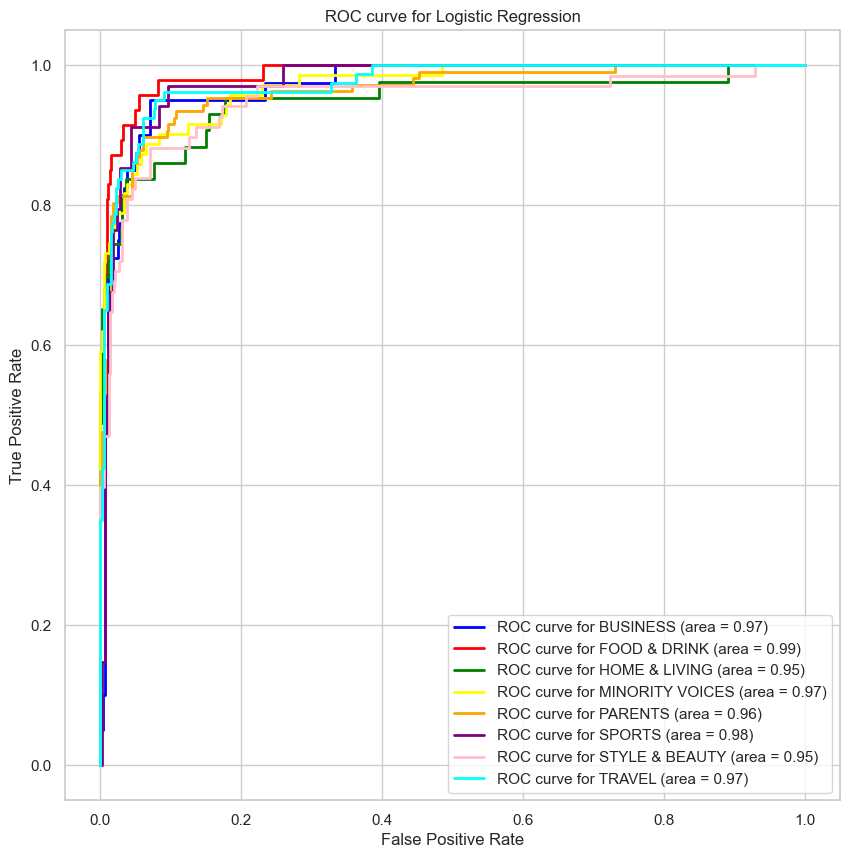

In [539]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
# plot the ROC curve
y_test_bin = label_binarize(y_test, classes=logistic_model.classes_)
y_score = logistic_model.decision_function(X_test_vec)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# plot the curves
plt.figure(figsize=(10, 10))
colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'cyan', 'magenta', 'brown']
for (idx, color) in zip(range(n_classes), colors):
    plt.plot(fpr[idx], tpr[idx], color=color, lw=2, label='ROC curve for {} (area = {:.2f})'.format(logistic_model.classes_[idx], roc_auc[idx]))
# add legend
plt.legend(loc='lower right')
# add title and axis labels
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [540]:
# hyperparameter tuning
# C (inverse regularization strength) hyperparameter tuning
# penalty (type of regularization) hyperparameter tuning
# solver (optimization algorithm) hyperparameter tuning
# class_weight (class imbalance) hyperparameter tuning
# max_iter (maximum number of iterations) hyperparameter tuning

# TODO: This doesn't work at the moment - most fits fail
# for now just do C and penalty
# from sklearn.model_selection import GridSearchCV
# # define the grid
# grid = dict()
# grid['C'] = [0.01, 0.1, 1.0]
# grid['penalty'] = ['l1', 'l2', 'elasticnet']
# # define the grid search
# search = GridSearchCV(logistic_model, grid, scoring='accuracy', cv=5, n_jobs=-1)
# # perform the search
# results = search.fit(X_train_vec, y_train)
# # summarize
# print('Mean Accuracy: %.3f' % results.best_score_)
# print('Config: %s' % results.best_params_)

##### KNN

In [541]:
# kNN model
# TODO: cross-validation to find the best k (7:11)
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train_vec, y_train)
knn_predictions = knn_model.predict(X_test_vec)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("kNN Accuracy:", knn_accuracy)

kNN Accuracy: 0.7408163265306122


3 seconds on 10%

In [542]:
# training accuracy
knn_predictions_train = knn_model.predict(X_train_vec)
knn_accuracy_train = accuracy_score(y_train, knn_predictions_train)
print("kNN Training Accuracy:", knn_accuracy_train)

kNN Training Accuracy: 0.8384458077709611


KNN prediction on train takes 9 seconds (longer than fitting)

##### Naive Bayes

In [543]:
# Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_predictions = nb_model.predict(X_test_vec)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.6204081632653061


In [544]:
# training accuracy
nb_predictions_train = nb_model.predict(X_train_vec)
nb_accuracy_train = accuracy_score(y_train, nb_predictions_train)
print("Naive Bayes Training Accuracy:", nb_accuracy_train)

Naive Bayes Training Accuracy: 0.8624744376278118


0.1 second on 10%

##### SVM

In [627]:
# SVM model
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.svm import SVC
svm_model = SVC(C=100, kernel='rbf') # default kernel is rbf and default C is 1.0
# TODO: cross-validation to find the best C and kernel
svm_model.fit(X_train_vec, y_train)
svm_predictions = svm_model.predict(X_test_vec)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


SVM Accuracy: 0.7836734693877551


1 min 20 on 10%

In [370]:
# training accuracy
svm_predictions_train = svm_model.predict(X_train_vec)
svm_accuracy_train = accuracy_score(y_train, svm_predictions_train)
print("SVM Training Accuracy:", svm_accuracy_train)

SVM Training Accuracy: 1.0


SVM prediction takes 37 seconds on train

##### Decision Tree

In [371]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_vec, y_train)
predicted_dt = dt.predict(X_test_vec)
accuracy_dt = accuracy_score(y_test, predicted_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.6469387755102041


15 seconds on 10%

In [372]:
# training accuracy
predicted_dt_train = dt.predict(X_train_vec)
accuracy_dt_train = accuracy_score(y_train, predicted_dt_train)
print("Decision Tree Training Accuracy:", accuracy_dt_train)

Decision Tree Training Accuracy: 1.0


##### Random Forest

In [373]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)
predicted_rf = rf.predict(X_test_vec)
accuracy_rf = accuracy_score(y_test, predicted_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.7816326530612245


1 min 40 on 10%

In [374]:
# training accuracy
predicted_rf_train = rf.predict(X_train_vec)
accuracy_rf_train = accuracy_score(y_train, predicted_rf_train)
print("Random Forest Training Accuracy:", accuracy_rf_train)

Random Forest Training Accuracy: 1.0


##### Bagging

In [375]:
# Random Forest model
from sklearn.ensemble import BaggingClassifier

model_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=14, random_state=8678686)
model_bagging.fit(X_train_vec, y_train)
pred_bagging = model_bagging.predict(X_test_vec)
result_bagging = accuracy_score(y_test, pred_bagging)
print("Bagging Accuracy:", result_bagging)

Bagging Accuracy: 0.6918367346938775


2 min 40 run time on 10%

In [376]:
# training accuracy
pred_bagging_train = model_bagging.predict(X_train_vec)
result_bagging_train = accuracy_score(y_train, pred_bagging_train)
print("Bagging Training Accuracy:", result_bagging_train)

Bagging Training Accuracy: 0.9851738241308794


##### Boosting

Attempting Gradient Boosting classification (a boosting method)

In [377]:
# Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_vec, y_train)
gb_predictions = gb_model.predict(X_test_vec)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Gradient Boosting Accuracy:", gb_accuracy)

Gradient Boosting Accuracy: 0.7653061224489796


11 min run time on 10%

In [378]:
# train accuracy
gb_predictions_train = gb_model.predict(X_train_vec)
gb_accuracy_train = accuracy_score(y_train, gb_predictions_train)
print("Gradient Boosting Training Accuracy:", gb_accuracy_train)

Gradient Boosting Training Accuracy: 0.995398773006135


##### AdaBoosting

In [379]:
from sklearn.ensemble import AdaBoostClassifier


model_boosting = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=8678686)
model_boosting.fit(X_train_vec, y_train)
pred_boosting = model_boosting.predict(X_test_vec)
result_boosting = accuracy_score(y_test, pred_boosting)
print("AdaBoosting Accuracy:", result_boosting)

AdaBoosting Accuracy: 0.6591836734693878


17 min on 10%

In [380]:
adaboost_accuracy = result_boosting

In [381]:
# train accuracy
pred_boosting_train = model_boosting.predict(X_train_vec)
result_adaboost_train = accuracy_score(y_train, pred_boosting_train)
print("AdaBoosting Training Accuracy:", result_adaboost_train)

AdaBoosting Training Accuracy: 1.0


##### XGBoosting

In [286]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)
y_encoded_test = label_encoder.fit_transform(y_test)
model_xgb = XGBClassifier()
model_xgb.fit(X_train_vec, y_encoded_train)
pred_xgb = model_xgb.predict(X_test_vec)
result_xgb = accuracy_score(y_encoded_test, pred_xgb)
print("XGBoost Accuracy:", result_xgb)

XGBoost Accuracy: 0.789795918367347


19 seconds on 10%

In [56]:
# train accuracy
pred_xgb_train = model_xgb.predict(X_train_vec)
result_xgb_train = accuracy_score(y_encoded_train, pred_xgb_train)
print("XGBoost Training Accuracy:", result_xgb_train)

XGBoost Training Accuracy: 0.9974437627811861


##### Neural Network

In [384]:
# Neural Network model
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier()
nn_model.fit(X_train_vec, y_train)
nn_predictions = nn_model.predict(X_test_vec)
nn_accuracy = accuracy_score(y_test, nn_predictions)
print("Neural Network Accuracy:", nn_accuracy)

Neural Network Accuracy: 0.8346938775510204


17 minutes on 10%

In [385]:
# train accuracy
nn_predictions_train = nn_model.predict(X_train_vec)
nn_accuracy_train = accuracy_score(y_train, nn_predictions_train)
print("Neural Network Training Accuracy:", nn_accuracy_train)

Neural Network Training Accuracy: 1.0


#### Majority Classifier

In [386]:
# majority in training set
majority_category = y_train.value_counts().idxmax()
accuracy_majority_train = accuracy_score(y_train, [majority_category]*len(y_train))
# majority in test set
accuracy_majority = accuracy_score(y_test, [majority_category]*len(y_test))
print("Majority classifier Training Accuracy:", accuracy_majority_train)
print("Majority classifier Test Accuracy:", accuracy_majority)

Majority classifier Training Accuracy: 0.19887525562372188
Majority classifier Test Accuracy: 0.21836734693877552


# Performance Comparison

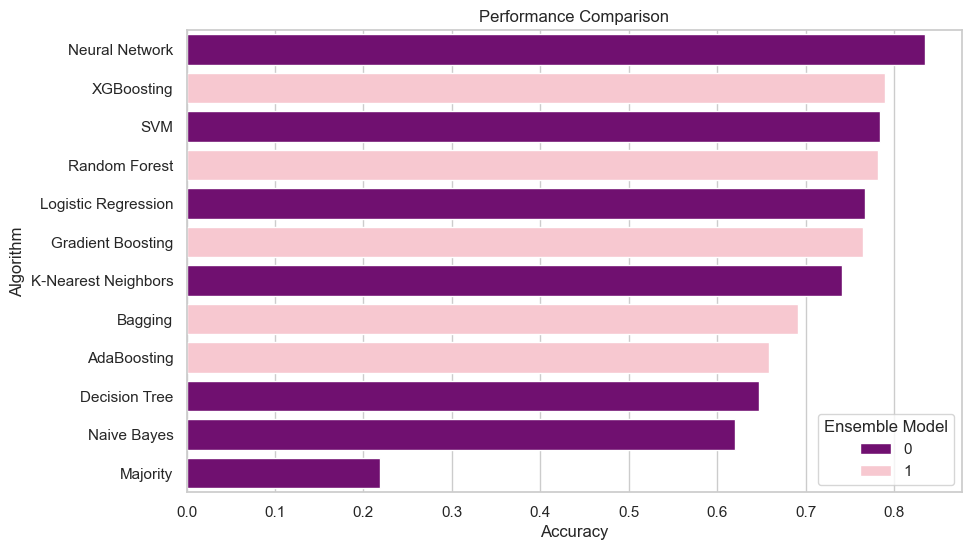

In [387]:
algo_names = ["Majority", "Logistic Regression", "K-Nearest Neighbors", "Naive Bayes", "SVM", "Decision Tree", "Random Forest", "Bagging", "Gradient Boosting", "AdaBoosting", "XGBoosting", "Neural Network"]
performances = [accuracy_majority, logistic_accuracy, knn_accuracy, nb_accuracy, svm_accuracy, accuracy_dt, accuracy_rf, result_bagging, gb_accuracy, adaboost_accuracy, result_xgb, nn_accuracy] #TODO: Change 0 to result_boosting
ensemble_model = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

result_df = pd.DataFrame({'Algorithm': algo_names, 'Performance': performances, 'Ensemble Model': ensemble_model})
result_df = result_df.sort_values(by='Performance', ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Performance', y='Algorithm', hue='Ensemble Model', data=result_df, dodge=False, palette={0: 'purple', 1: 'pink'})
plt.xlabel('Accuracy')
plt.ylabel('Algorithm') 
plt.title('Performance Comparison')
plt.legend(title='Ensemble Model', loc='lower right')
plt.show()

In [388]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [389]:
algo_names = ["Majority", "Logistic Regression", "K-Nearest Neighbors", "Naive Bayes", "SVM", "Decision Tree", "Random Forest", "Bagging", "Gradient Boosting", "AdaBoosting", "XGBoosting", "Neural Network"]*2
test_performances = [accuracy_majority, logistic_accuracy, knn_accuracy, nb_accuracy, svm_accuracy, accuracy_dt, accuracy_rf, result_bagging, gb_accuracy, adaboost_accuracy, result_xgb, nn_accuracy]
train_performances = [accuracy_majority_train, logistic_accuracy_train, knn_accuracy_train, nb_accuracy_train, svm_accuracy_train, accuracy_dt_train, accuracy_rf_train, result_bagging_train, gb_accuracy_train, result_adaboost_train, result_xgb_train, nn_accuracy_train]
performance_set = ['Test']*12 + ['Train']*12
performances = test_performances + train_performances
ensemble_model = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]*2

result_df = pd.DataFrame({'Algorithm': algo_names, 'Performance': performances, 'performance_set': performance_set, 'Ensemble Model': ensemble_model})
result_df = result_df.sort_values(by='Performance', ascending=False)

In [390]:
# order the algorithms by the performance on the test set
algo_names = result_df[result_df['performance_set'] == 'Test']['Algorithm'].tolist()
# sort the df by the order of algo_names
result_df['Algorithm'] = pd.Categorical(result_df['Algorithm'], categories=algo_names, ordered=True)

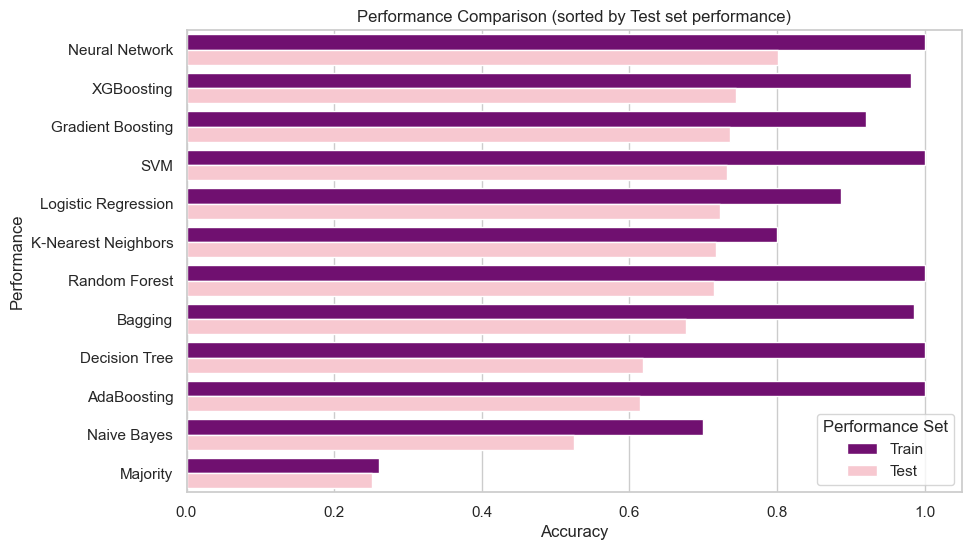

In [123]:
# plot a grouped bar chart
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(y='Algorithm', x='Performance', hue='performance_set', data=result_df, dodge=True, palette={'Train': 'purple', 'Test': 'pink'})
plt.xlabel('Accuracy')
plt.ylabel('Performance')
plt.title('Performance Comparison (sorted by Test set performance)')
plt.legend(title='Performance Set', loc='lower right')
plt.show()

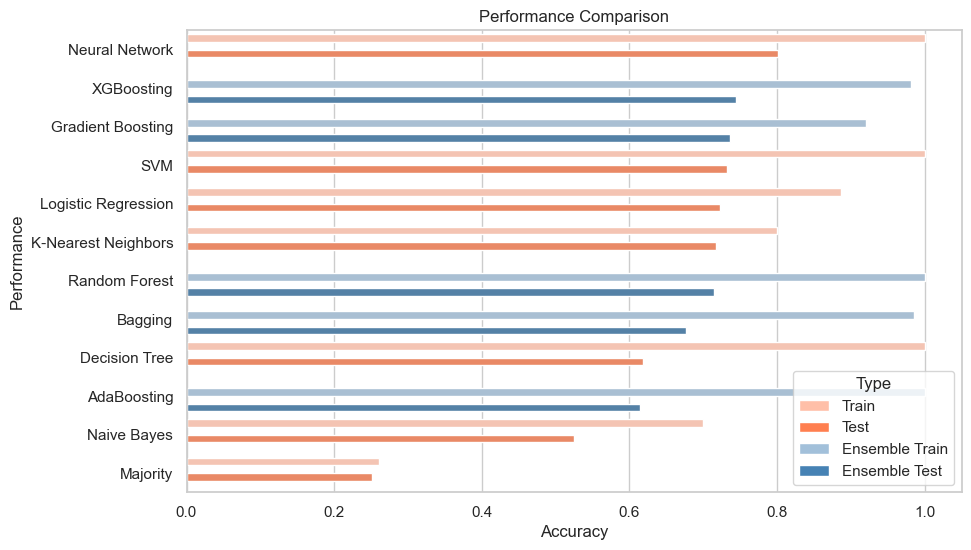

In [124]:
# Define a function to lighten the color
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1 - amount) to each channel.
    """
    import matplotlib.colors as mcolors
    color_rgb = mcolors.hex2color(color)
    new_color = [min(1, c + (1 - c) * amount) for c in color_rgb]
    return mcolors.to_hex(new_color)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# combine ensemble and performance set columns
result_df['performance_set_ensemble'] = result_df.apply(lambda row: row['performance_set'] + '_' + str(row['Ensemble Model']), axis=1)

# Use 'palette' to specify the colors for 'Train' and 'Test' sets
sns.barplot(y='Algorithm', 
            x='Performance', 
            hue='performance_set_ensemble', 
            data=result_df, 
            dodge=True, 
            palette={'Train_0': lighten_color('coral'), 'Test_0': 'coral',
                     'Train_1': lighten_color('steelblue'), 'Test_1': 'steelblue'})
plt.xlabel('Accuracy')
plt.ylabel('Performance')
plt.title('Performance Comparison')
plt.legend(title='Type', loc='lower right', 
           labels=['Train', 'Test', 'Ensemble Train', 'Ensemble Test'],
           handles = [plt.Rectangle((0,0),1,1,fc=lighten_color('coral')), plt.Rectangle((0,0),1,1,fc='coral'),
                      plt.Rectangle((0,0),1,1,fc=lighten_color('steelblue')), plt.Rectangle((0,0),1,1,fc='steelblue')])
plt.show()


# Hyperparameters tuning for SVM

In [632]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [641]:
C = list(np.logspace(1,16,num=15, endpoint=False))
gamma = list(np.logspace(-13,-2,num=15, endpoint=False))
params = {'C': C,
          'kernel': ['rbf'],
          'gamma': gamma}

In [642]:
skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)

In [643]:
best_svm = GridSearchCV(SVC(), param_grid= params, cv= skf, verbose= True)

In [644]:
%%time
best_svm.fit(X_train_vec, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
CPU times: total: 17min 30s
Wall time: 8min 52s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [10.0, 100.0, 1000.0, 10000.0, 100000.0,
                               1000000.0, 10000000.0, 100000000.0, 1000000000.0,
                               10000000000.0, 100000000000.0, 1000000000000.0,
                               10000000000000.0, 100000000000000.0,
                               1000000000000000.0],
                         'gamma': [1e-13, 5.411695265464627e-13,
                                   2.928644564625237e-12,
                                   1.5848931924611107e-11,
                                   8.576958985908946e-11,
                                   4.6415888336127727e-10,
                                   2.511886431509572e-09,
                                   1.3593563908785241e-08,
                                   7.356422544596406e-08, 3.981071705534969e-07,
                                   2.1544346900318822e-06,
                                   1.165914401179831e-05, 6.309573444801917e-05,
                                   0.0003414548873833601,
                                   0.001847849797422287],
                         'kernel': ['rbf']},
             verbose=True)

In [645]:
print(best_svm.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(best_svm.best_estimator_)

{'C': 100000.0, 'gamma': 1.165914401179831e-05, 'kernel': 'rbf'}
SVC(C=100000.0, gamma=1.165914401179831e-05)


In [646]:
best_svm_predictions = best_svm.predict(X_test_vec)
best_svm_accuracy = accuracy_score(y_test, best_svm_predictions)
print("SVM Accuracy:", best_svm_accuracy)

SVM Accuracy: 0.8408163265306122


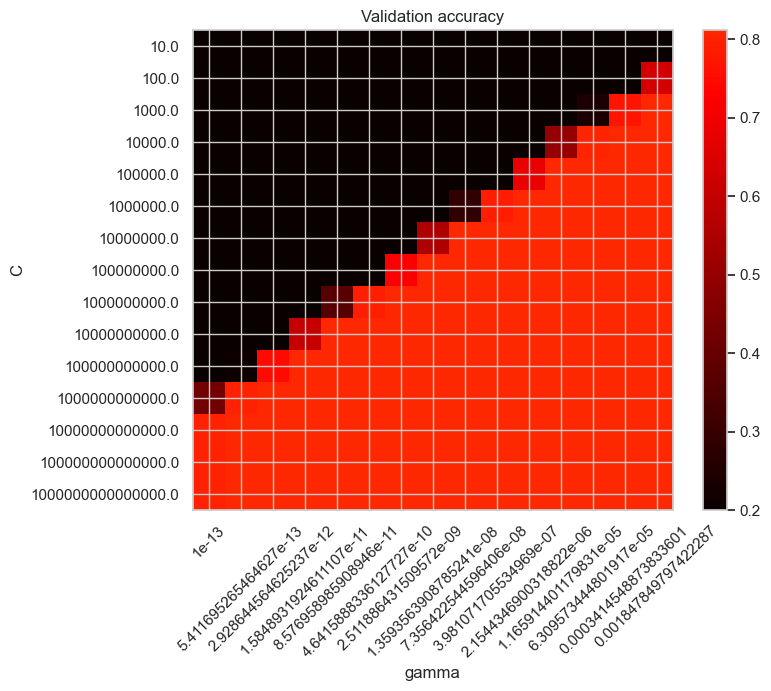

In [647]:
scores = best_svm.cv_results_["mean_test_score"].reshape(len(C), len(gamma))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma)), gamma, rotation=45)
plt.yticks(np.arange(len(C)), C)
plt.title("Validation accuracy")
plt.show()

In [614]:
def fitness_func(ga_instance, solution, solution_idx):
    # Extract C and gamma values from the solution
    C_value = solution[0]
    gamma_value = solution[1]

    # Create an SVM model with the specified parameters
    svm_model = SVC(C=C_value, gamma=gamma_value, kernel='rbf')

    # Train the SVM model
    svm_model.fit(X_train_vec, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test_vec)

    # Calculate accuracy as the fitness value
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [615]:
def on_generation(ga_instance):
    # Get the best solutions and their fitness values
    solutions = ga_instance.population
    fitness_values = ga_instance.last_generation_fitness

    # Sort solutions based on fitness values
    sorted_indices = np.argsort(fitness_values)[::-1]  # Descending order
    top_5_indices = sorted_indices[:5]

    # Print the top 5 solutions and their accuracy
    print("\nTop 5 Solutions at Generation", ga_instance.generations_completed)
    for idx in top_5_indices:
        print("Solution:", solutions[idx])
        print("Accuracy:", fitness_values[idx])
    

In [616]:
import pygad

In [617]:
gene_space = np.array([list(np.logspace(-5,15,num=50, endpoint=False)),  # C parameter
                     list(np.logspace(-15,5,num=50, endpoint=False))])  # gamma parameter

In [618]:
ga_instance = pygad.GA(num_generations=15,
                      num_parents_mating=10,
                      sol_per_pop=50,
                      num_genes=2,
                      fitness_func=fitness_func,
                      gene_space=gene_space,
                      mutation_percent_genes=10,
                      on_generation=on_generation)

c:\Users\oskik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resutled in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


In [619]:
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.svm import SVC
svm_model = SVC(C=1000000, gamma=0.0001, kernel='rbf') # default kernel is rbf and default C is 1.0
# TODO: cross-validation to find the best C and kernel
svm_model.fit(X_train_vec, y_train)
svm_predictions = svm_model.predict(X_test_vec)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


SVM Accuracy: 0.8408163265306122


In [620]:
ga_instance.run()



Top 5 Solutions at Generation 1
Solution: [6.30957344e+13 2.51188643e-11]
Accuracy: 0.8408163265306122
Solution: [6.30957344e+07 2.51188643e-05]
Accuracy: 0.8408163265306122
Solution: [1.58489319e+10 3.98107171e-06]
Accuracy: 0.8408163265306122
Solution: [1.00000000e+07 1.58489319e-04]
Accuracy: 0.8408163265306122
Solution: [6.30957344e+11 2.51188643e-05]
Accuracy: 0.8408163265306122

Top 5 Solutions at Generation 2
Solution: [6.30957344e+07 1.58489319e-04]
Accuracy: 0.8408163265306122
Solution: [6.30957344e+13 6.30957344e-05]
Accuracy: 0.8408163265306122
Solution: [6.30957344e+13 6.30957344e-07]
Accuracy: 0.8408163265306122
Solution: [2.51188643e+13 1.00000000e-11]
Accuracy: 0.8408163265306122
Solution: [6.30957344e+05 3.98107171e-04]
Accuracy: 0.8408163265306122

Top 5 Solutions at Generation 3
Solution: [6.30957344e+11 3.98107171e-08]
Accuracy: 0.8408163265306122
Solution: [3.98107171e+14 6.30957344e-11]
Accuracy: 0.8408163265306122
Solution: [1.58489319e+12 6.30957344e-05]
Accurac

In [624]:

# Get the best solution found by the GA
best_solution = ga_instance.best_solution()

# Print the best solution and its corresponding fitness value
print("Best Solution:", best_solution[0])
print("Best Fitness Value:", best_solution[1])

# Extract the best C and gamma values
best_C = best_solution[0][0]
best_gamma = best_solution[0][1]

# Train an SVM model with the best parameters
best_svm_model = SVC(C=best_C, gamma=best_gamma, kernel='rbf')
best_svm_model.fit(X_train_vec, y_train)

# Make predictions on the test set using the best model
y_pred_best = best_svm_model.predict(X_test_vec)

# Print the accuracy of the best model on the test set
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy of the Best Model:", accuracy_best)

Best Solution: [2.51188643e+11 1.00000000e-03]
Best Fitness Value: 0.8408163265306122
Accuracy of the Best Model: 0.8408163265306122


In [628]:
print(classification_report(y_test, svm_predictions)) 

                 precision    recall  f1-score   support

       BUSINESS       0.80      0.60      0.69        40
   FOOD & DRINK       1.00      0.66      0.79        47
  HOME & LIVING       1.00      0.63      0.77        43
MINORITY VOICES       0.73      0.83      0.78        71
        PARENTS       0.69      0.93      0.80       107
         SPORTS       0.83      0.44      0.58        34
 STYLE & BEAUTY       0.84      0.85      0.85        68
         TRAVEL       0.78      0.88      0.82        80

       accuracy                           0.78       490
      macro avg       0.83      0.73      0.76       490
   weighted avg       0.81      0.78      0.78       490



In [629]:
print(classification_report(y_test, y_pred_best)) 

                 precision    recall  f1-score   support

       BUSINESS       0.74      0.85      0.79        40
   FOOD & DRINK       1.00      0.83      0.91        47
  HOME & LIVING       0.87      0.77      0.81        43
MINORITY VOICES       0.84      0.80      0.82        71
        PARENTS       0.83      0.92      0.87       107
         SPORTS       0.88      0.62      0.72        34
 STYLE & BEAUTY       0.86      0.87      0.86        68
         TRAVEL       0.81      0.89      0.85        80

       accuracy                           0.84       490
      macro avg       0.85      0.82      0.83       490
   weighted avg       0.85      0.84      0.84       490



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


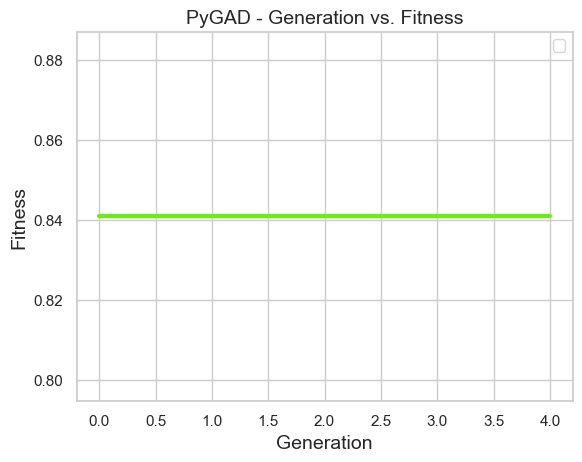

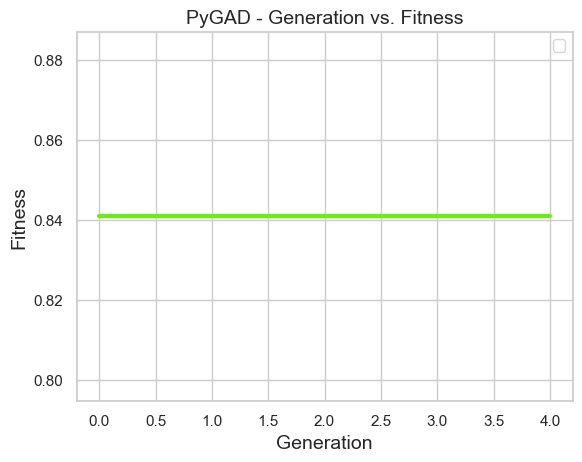

In [563]:
ga_instance.plot_fitness()

Hyperparameter Tuning for XGBoost

In [287]:
default_parameters = model_xgb.get_params()
default_parameters

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [288]:
# expliticity fit the model with the default parameters
xgb_model_explicit = XGBClassifier(**default_parameters)
model_xgb.fit(X_train_vec, y_encoded_train)
pred_xgb = model_xgb.predict(X_test_vec)
result_xgb = accuracy_score(y_encoded_test, pred_xgb)
print("XGBoost Accuracy:", result_xgb)

XGBoost Accuracy: 0.789795918367347


In [290]:
# CV performance of the default model
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model_xgb, X_train_vec, y_encoded_train, cv=5)
print("CV Scores:", cv_scores)
# mean CV score
print("Mean CV Score:", cv_scores.mean())

CV Scores: [0.73979592 0.75703325 0.77749361 0.72890026 0.7314578 ]
Mean CV Score: 0.746936165770656


In [292]:
xgb_model_linear = XGBClassifier(booster='gblinear')
xgb_model_linear.fit(X_train_vec, y_encoded_train)
# predictions
pred_xgb_linear = xgb_model_linear.predict(X_test_vec)
result_xgb_linear = accuracy_score(y_encoded_test, pred_xgb_linear)
print("XGBoost Accuracy:", result_xgb_linear)

XGBoost Accuracy: 0.7795918367346939


In [293]:
# cv performance of the linear model
cv_scores_linear = cross_val_score(xgb_model_linear, X_train_vec, y_encoded_train, cv=5)
print("CV Scores:", cv_scores_linear)
# mean CV score
print("Mean CV Score:", cv_scores_linear.mean())

CV Scores: [0.76530612 0.72890026 0.72634271 0.73401535 0.72378517]
Mean CV Score: 0.7356699201419699


In [125]:
from sklearn.model_selection import GridSearchCV
# grid search for XGBoost
grid = dict()
grid['eta'] = [0.01, 0.05, 0.075, 0.1, 0.11, 0.15, 0.2]
# define the grid search
grid['alpha'] = [0, 0.001, 0.005, 0.01, 0.05]
# grid['lambda'] = [0, 0.001, 0.005, 0.01, 0.05]
grid['n_estimators'] = [100, 200, 300]
search = GridSearchCV(XGBClassifier(booster = 'gblinear'), grid, scoring='accuracy', cv=2, n_jobs=-1, verbose=3)
# perform the search
results = search.fit(X_train_vec, y_encoded_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Fitting 2 folds for each of 105 candidates, totalling 210 fits
Mean Accuracy: 0.788
Config: {'alpha': 0, 'eta': 0.05, 'n_estimators': 200}


In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=2, scoring='accuracy', verbose=3)
results = grid_search.fit(X_train_vec, y_encoded_train)

results.best_estimator_
results.best_params_

Fitting 2 folds for each of 162 candidates, totalling 324 fits
[CV 1/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.713 total time=   1.3s
[CV 2/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.673 total time=   1.3s
[CV 1/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.9;, score=0.716 total time=   1.1s
[CV 2/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.9;, score=0.671 total time=   1.2s
[CV 1/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.708 total time=   1.1s
[CV 2/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.672 total time=   1.2s
[CV 1/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, subsample=0.8;, score=0.662 total time=   1.6s

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'subsample': 0.9}

In [77]:
results.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [126]:
results.best_score_

0.7883435582822086

## GA for XGBoost

In [157]:
def fitness_func_xgb(ga_instance, solution, solution_idx):
    # Extract parameters for XGBoost
    learning_rate = solution[0]
    max_depth = int(solution[1])
    min_child_weight = int(solution[2])
    subsample = solution[3]
    colsample_bytree = solution[4]
    # TODO:... add more parameters
    
    # Create XGB model with the specified parameters
    xgb_model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, 
                              min_child_weight=min_child_weight, subsample=subsample, 
                              colsample_bytree=colsample_bytree)

    # Train the XGB model
    xgb_model.fit(X_train_vec, y_encoded_train)

    # Make predictions on the test set
    y_pred = xgb_model.predict(X_test_vec)

    # Calculate accuracy as the fitness value
    # print(y_pred)
    # print(y_encoded_test)
    accuracy = accuracy_score(y_encoded_test, y_pred)

    return accuracy

In [158]:
def on_generation(ga_instance):
    # Get the best solutions and their fitness values
    solutions = ga_instance.population
    fitness_values = ga_instance.last_generation_fitness

    # Sort solutions based on fitness values
    sorted_indices = np.argsort(fitness_values)[::-1]  # Descending order
    top_5_indices = sorted_indices[:5]

    # Print the top 5 solutions and their accuracy
    print("\nTop 5 Solutions at Generation", ga_instance.generations_completed)
    for idx in top_5_indices:
        print("Solution:", solutions[idx])
        print("Accuracy:", fitness_values[idx])

In [159]:
# gene_space = np.array([list(np.logspace(-5,15,num=50, endpoint=False)),  # C parameter
#                      list(np.logspace(-15,5,num=50, endpoint=False))])  # gamma parameter

# gene space for XGBoost
gene_space = np.array([list(np.logspace(-5,1,num=50, endpoint=False)),  # learning_rate
                       list(range(3, 8)),  # max_depth
                       list(range(1, 6)),  # min_child_weight
                       list(np.linspace(0.8, 1.0, num=50)),  # subsample
                       list(np.linspace(0.8, 1.0, num=50))])  # colsample_bytree

C:\Users\benjo\AppData\Local\Temp\ipykernel_27232\3793424362.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gene_space = np.array([list(np.logspace(-5,1,num=50, endpoint=False)),  # learning_rate


In [160]:
import pygad
ga_instance = pygad.GA(num_generations=15,
                      num_parents_mating=10,
                      sol_per_pop=50,
                      num_genes=5,
                      fitness_func=fitness_func_xgb,
                      gene_space=gene_space,
                      mutation_percent_genes=10,
                      on_generation=on_generation)

c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\pygad\pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resutled in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


In [161]:
ga_instance.run()


Top 5 Solutions at Generation 1
Solution: [0.47863009 3.         2.         0.91428571 0.82040816]
Accuracy: 0.7775510204081633
Solution: [0.09120108 7.         1.         0.84081633 0.92653061]
Accuracy: 0.7714285714285715
Solution: [0.09120108 7.         1.         0.82857143 0.92653061]
Accuracy: 0.7714285714285715
Solution: [0.15848932 5.         2.         0.88979592 0.95510204]
Accuracy: 0.7714285714285715
Solution: [0.15848932 7.         2.         0.91020408 0.9755102 ]
Accuracy: 0.7693877551020408

Top 5 Solutions at Generation 2
Solution: [0.36307805 3.         2.         0.8244898  0.95918367]
Accuracy: 0.7836734693877551
Solution: [0.09120108 7.         1.         0.9877551  0.82040816]
Accuracy: 0.7836734693877551
Solution: [0.47863009 3.         2.         0.89795918 0.95510204]
Accuracy: 0.7795918367346939
Solution: [0.47863009 3.         2.         0.91428571 0.82040816]
Accuracy: 0.7775510204081633
Solution: [0.09120108 7.         1.         0.82857143 0.90204082]
Acc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


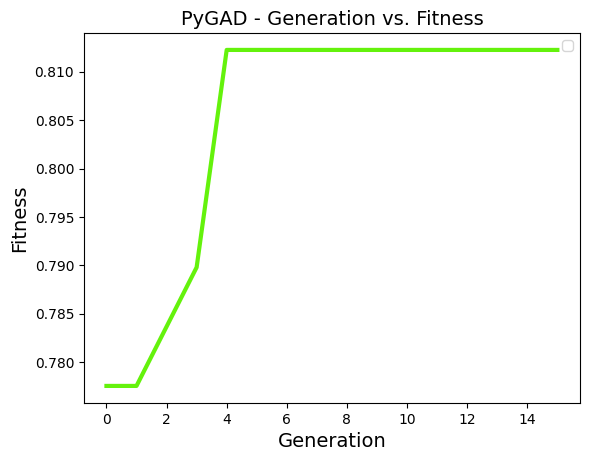

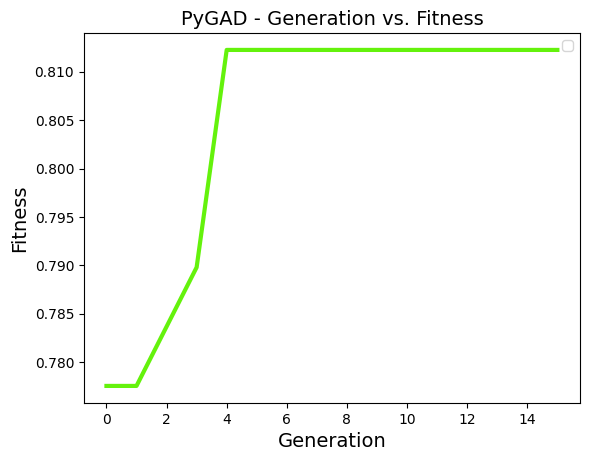

In [162]:
# plot results
ga_instance.plot_fitness()

In [167]:
# now for gblinear version
def fitness_func_xgb_linear(ga_instance, solution, solution_idx):
    # Extract parameters for XGBoost
    learning_rate = solution[0]
    n_estimators = int(solution[1])
    alpha = solution[2]
    lambda_value = solution[3]
    
    # Create XGB model with the specified parameters
    xgb_model = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                              alpha=alpha, reg_lambda=lambda_value, booster='gblinear')
    
    # Train the XGB model
    xgb_model.fit(X_train_vec, y_encoded_train)
    
    # Make predictions on the test set
    y_pred = xgb_model.predict(X_test_vec)
    
    # Calculate accuracy as the fitness value
    # print(y_pred)
    # print(y_encoded_test)
    accuracy = accuracy_score(y_encoded_test, y_pred)
    
    return accuracy
    

In [168]:
# gene space for XGBoost
gene_space = np.array([list(np.logspace(-5,1,num=50, endpoint=False)),  # learning_rate
                       list(range(100, 500, 10)),  # n_estimators
                       list(np.logspace(-5,1,num=50, endpoint=False)),  # alpha
                       list(np.logspace(-5,1,num=50, endpoint=False))])  # lambda

C:\Users\benjo\AppData\Local\Temp\ipykernel_27232\3340099768.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gene_space = np.array([list(np.logspace(-5,1,num=50, endpoint=False)),  # learning_rate


In [169]:
# define the GA instance
import pygad
ga_instance = pygad.GA(num_generations=15,
                      num_parents_mating=10,
                      sol_per_pop=50,
                      num_genes=4,
                      fitness_func=fitness_func_xgb_linear,
                      gene_space=gene_space,
                      mutation_percent_genes=10,
                      on_generation=on_generation)

c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\pygad\pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resutled in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


In [170]:
# run the GA
ga_instance.run()


Top 5 Solutions at Generation 1
Solution: [3.01995172e-02 3.50000000e+02 2.29086765e-05 1.20226443e-04]
Accuracy: 0.8387755102040816
Solution: [1.73780083e-02 4.90000000e+02 2.29086765e-05 3.01995172e-05]
Accuracy: 0.8367346938775511
Solution: [1.58489319e-01 3.50000000e+02 2.29086765e-05 5.24807460e-05]
Accuracy: 0.8306122448979592
Solution: [3.98107171e-02 3.50000000e+02 2.29086765e-05 5.24807460e-05]
Accuracy: 0.8306122448979592
Solution: [3.63078055e-01 3.80000000e+02 5.24807460e-05 6.91830971e-05]
Accuracy: 0.8224489795918367

Top 5 Solutions at Generation 2
Solution: [3.01995172e-02 3.50000000e+02 2.29086765e-05 1.20226443e-04]
Accuracy: 0.8387755102040816
Solution: [1.73780083e-02 3.50000000e+02 2.29086765e-05 1.20226443e-04]
Accuracy: 0.8387755102040816
Solution: [1.31825674e-02 3.80000000e+02 5.24807460e-05 6.91830971e-05]
Accuracy: 0.8367346938775511
Solution: [3.98107171e-02 3.70000000e+02 2.29086765e-05 5.24807460e-05]
Accuracy: 0.8306122448979592
Solution: [3.63078055e-01

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


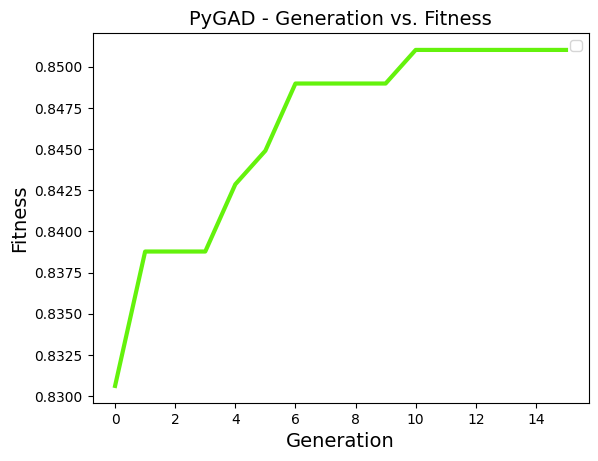

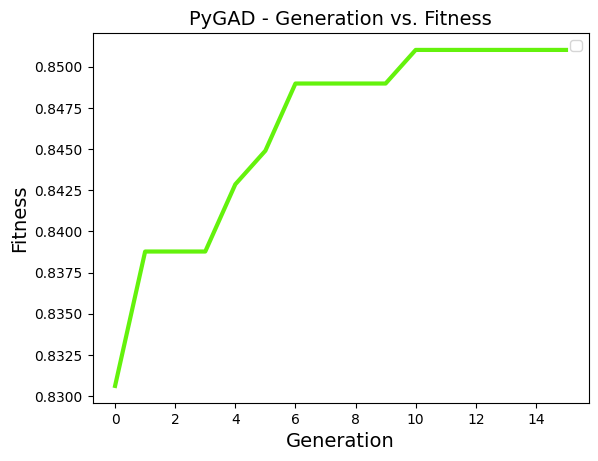

In [171]:
# plot results
ga_instance.plot_fitness()

In [173]:
ga_instance.best_solution()

(array([1.73780083e-02, 1.90000000e+02, 1.31825674e-05, 3.98107171e-05]),
 0.8530612244897959,
 15)